In [ ]:
import jax.numpy as jnp
import jinns
import jax.random as random
from jax import vmap
import jax

import equinox as eqx
import matplotlib.pyplot as plt

import deepxde as dde
import os

key = random.PRNGKey(2)
key, subkey = random.split(key)

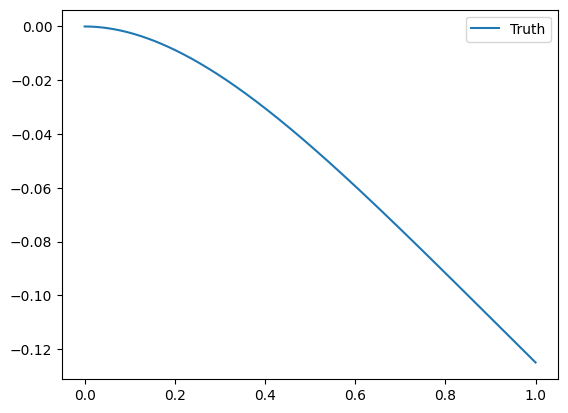

In [2]:
def u_true(x):
    return -(1 / 24) * x**4 + (1 / 6) * x**3 - (1 / 4) * x**2


v_u_true = vmap(u_true)

xs = jnp.linspace(0, 1, 1000)
plt.plot(xs, v_u_true(xs), label="Truth")
plt.legend()

## Solving Euler-Beam with Jinns

Create the neural network architecture for the PINN with `equinox`.

In [3]:
dim = 1
# same architecture as in DeepXDE example
eqx_list = (
    (eqx.nn.Linear, dim, 20),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 20, 20),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 20, 20),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 20, 1),
    # (jnp.exp,)
)
key, subkey = random.split(key)
u, init_nn_params = jinns.nn.PINN_MLP.create(
    key=subkey, eqx_list=eqx_list, eq_type="statio_PDE"
)

In [4]:
n = 320
nb = 2
omega_batch_size = 32
omega_border_batch_size = None  # no mini-batches in dimension 1
dim = 1
min_pts = (0.0,)
max_pts = (1.0,)
method = "grid"

key, subkey = random.split(key)
train_data = jinns.data.CubicMeshPDEStatio(
    key=subkey,
    n=n,
    nb=nb,
    omega_batch_size=omega_batch_size,
    omega_border_batch_size=omega_batch_size,
    dim=dim,
    min_pts=min_pts,
    max_pts=max_pts,
    method=method,
)

In [5]:
from jinns.loss import PDEStatio
from functools import partial


class EulerBeamLoss(PDEStatio):
    def equation(self, x, u, params):
        x = x[0]
        u_x = lambda x: partial(u, params=params)(x).squeeze()

        dx4 = jax.grad(jax.grad(jax.grad(jax.grad(u_x))))(x)
        return jnp.array([dx4]) + 1

In [6]:
init_params = jinns.parameters.Params(eq_params={}, nn_params=init_nn_params)

In [7]:
euler_beam_loss = EulerBeamLoss()
print(xs[0])
euler_beam_loss.equation(xs[0, None], u, init_params)

0.0


Array([0.99908787], dtype=float32)

In [8]:
params = init_params

In [9]:
loss_weights = jinns.loss.LossWeightsPDEStatio(dyn_loss=1.0, boundary_loss=1.0)

In [10]:
loss = jinns.loss.LossPDEStatio(
    u=u,
    loss_weights=loss_weights,
    dynamic_loss=euler_beam_loss,
    omega_boundary_fun=lambda _: jnp.array(
        None
    ),  # ignored for this example, hard-coded in euler-beam
    omega_boundary_condition="euler-beam",
    params=init_params,
)

In [11]:
# Testing the loss function
losses_and_grad = jax.value_and_grad(loss.evaluate, 0, has_aux=True)
key, subkey = random.split(key)
train_data, batch = train_data.get_batch()
losses, grads = losses_and_grad(init_params, batch=batch)


l_tot, dict_losses = losses
print(f"total loss: {l_tot:.2f}")
print(f"Individual losses: { {key: f'{val:.2f}' for key, val in dict_losses.items()} }")

total loss: 0.97
Individual losses: {'dyn_loss': '0.89', 'boundary_loss': '0.07'}


In [12]:
# Optimizer
import optax

tx = optax.adamw(learning_rate=1e-4)
n_iter = int(6000)
key, subkey = random.split(key, 2)

In [13]:
params, total_loss_list, loss_by_term_dict, data, loss, _, _, _, _, _ = jinns.solve(
    init_params=params,
    data=train_data,
    optimizer=tx,
    loss=loss,
    n_iter=n_iter,
    print_loss_every=100,
)


Compilation took
 7.284899473190308 

[train] Iteration 0: loss value = 0.93153315782547
[train] Iteration 100: loss value = 0.4863223433494568
[train] Iteration 200: loss value = 0.3793891668319702
[train] Iteration 300: loss value = 0.26924216747283936
[train] Iteration 400: loss value = 0.1896509826183319
[train] Iteration 500: loss value = 0.1062219887971878
[train] Iteration 600: loss value = 0.06380311399698257
[train] Iteration 700: loss value = 0.048274196684360504
[train] Iteration 800: loss value = 0.04746886342763901
[train] Iteration 900: loss value = 0.03547288849949837
[train] Iteration 1000: loss value = 0.03308944031596184
[train] Iteration 1100: loss value = 0.03033839724957943
[train] Iteration 1200: loss value = 0.024287797510623932
[train] Iteration 1300: loss value = 0.02562376856803894
[train] Iteration 1400: loss value = 0.022885240614414215
[train] Iteration 1500: loss value = 0.019396984949707985
[train] Iteration 1600: loss value = 0.019443459808826447
[train

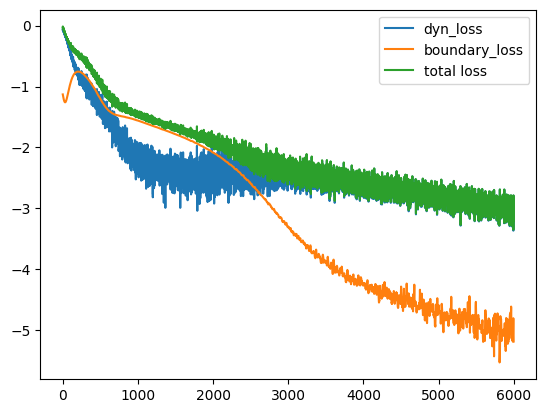

In [14]:
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list), label="total loss")
plt.legend()
plt.show()

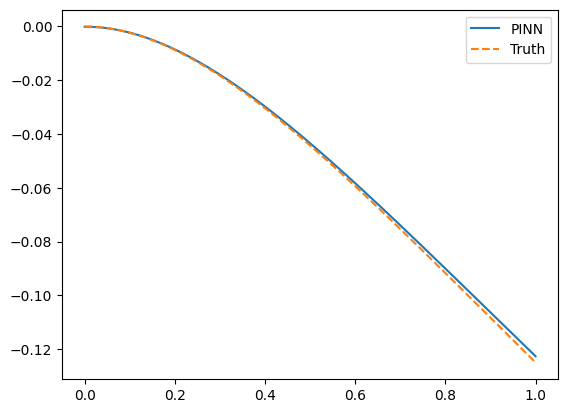

In [15]:
plt.plot(xs, vmap(lambda x: u(x, params))(xs), label="PINN")
plt.plot(xs, v_u_true(xs), "--", label="Truth")
plt.legend()

In [ ]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, paddle"""


DDE_BACKEND = "tensorflow"
os.environ["DDE_BACKEND"] = DDE_BACKEND


def ddy(x, y):
    return dde.grad.hessian(y, x)


def dddy(x, y):
    return dde.grad.jacobian(ddy(x, y), x)


def pde(x, y):
    dy_xx = ddy(x, y)
    dy_xxxx = dde.grad.hessian(dy_xx, x)
    return dy_xxxx + 1


def boundary_l(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 0)


def boundary_r(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 1)


def func(x):
    return -(x**4) / 24 + x**3 / 6 - x**2 / 4


geom = dde.geometry.Interval(0, 1)

bc1 = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_l)
bc2 = dde.icbc.NeumannBC(geom, lambda x: 0, boundary_l)
bc3 = dde.icbc.OperatorBC(geom, lambda x, y, _: ddy(x, y), boundary_r)
bc4 = dde.icbc.OperatorBC(geom, lambda x, y, _: dddy(x, y), boundary_r)

data = dde.data.PDE(
    geom,
    pde,
    [bc1, bc2, bc3, bc4],
    num_domain=10,
    num_boundary=2,
    solution=func,
    num_test=100,
)
layer_size = [1] + [20] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(iterations=10000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Compiling model...


AttributeError: 'EvalTrace' object has no attribute 'level'